In [54]:
from skimage import io, exposure, transform, filters, segmentation, color
from skimage.future import graph
import matplotlib.pyplot as plt
import numpy as np

## Read image data

(-0.5, 511.5, 511.5, -0.5)

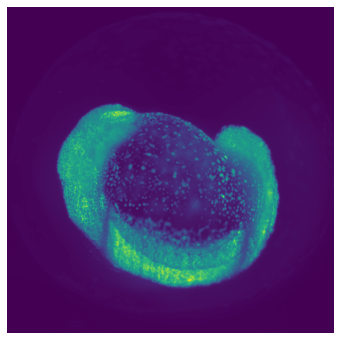

In [46]:
### download the dataset from: https://drive.google.com/drive/folders/1_mnNa7crtrIO4-qtJPx45eBCtBT4UZ7p?usp=sharing

stack = io.imread('raw.tif') # stack of frames
slice = stack[100] # pick one frame
slice = transform.resize(exposure.rescale_intensity(slice, out_range=(0, 1)), (512, 512)) # normalize and resize
fig = plt.figure(figsize=(6, 6))
plt.imshow(slice)
plt.axis('off')

## First, threshold the backgroud

(-0.5, 511.5, 511.5, -0.5)

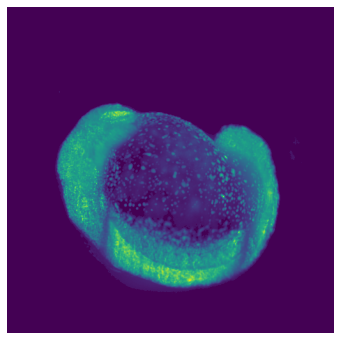

In [47]:
mask = slice > np.percentile(slice, 70) # pick a threshold that removes the background
slice_t = slice * mask
fig = plt.figure(figsize=(6, 6))
plt.imshow(slice_t)
plt.axis('off')

## Generate superpixels (over-segmented intermediate resutls)

(-0.5, 511.5, 511.5, -0.5)

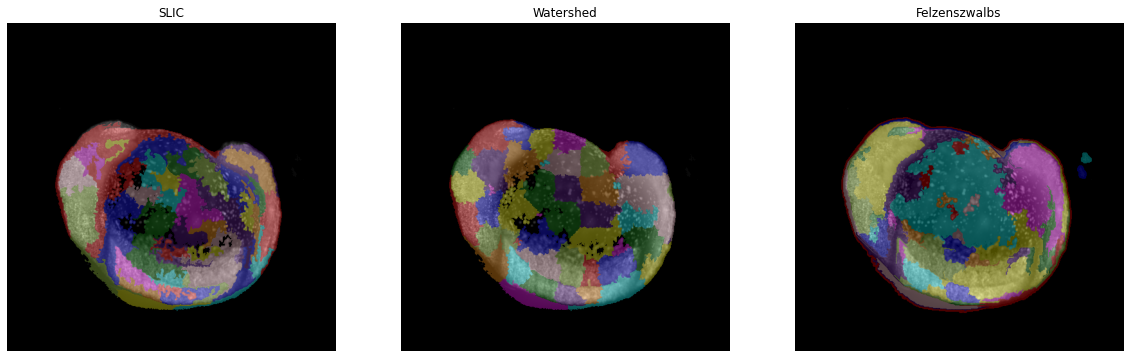

In [116]:
# Adopted from: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

### slice
segments_slic = segmentation.slic(slice_t, n_segments=100, compactness=0.01, sigma=1, start_label=1, mask=mask)
out_slic = color.label2rgb(segments_slic, slice_t, bg_label=0)

### watershed
gradient = filters.sobel(slice_t)
segments_watershed = segmentation.watershed(gradient, markers=50, compactness=0.001, mask=mask)
out_watershed = color.label2rgb(segments_watershed, slice_t, bg_label=0)

### felzenszwalb’s efficient graph based segmentation
segments_fz = segmentation.felzenszwalb(slice_t, scale=50, sigma=1, min_size=200)
out_fz = color.label2rgb(segments_fz, slice_t, bg_label=0)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(out_slic)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(out_watershed)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(out_fz)
ax[2].axis('off')

## Merge segments

(-0.5, 511.5, 511.5, -0.5)

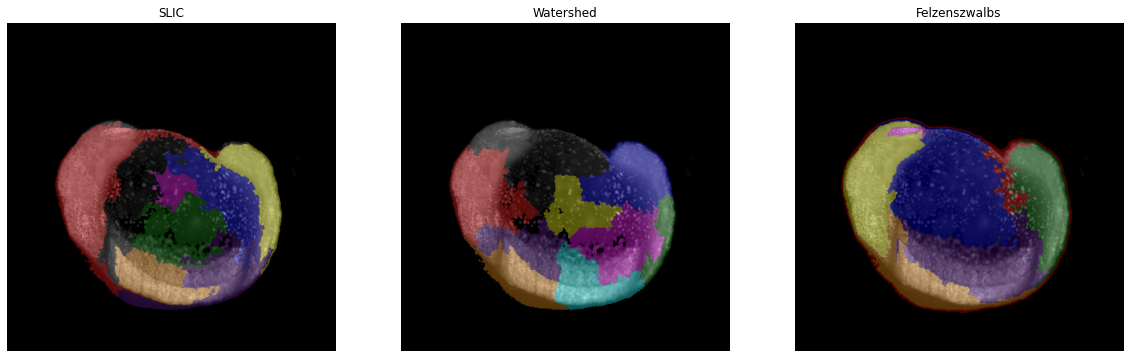

In [115]:
# Adopted from: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_ncut.html

### n-cut
def n_cut(img, segments):
    g = graph.rag_mean_color(img, segments, mode='similarity', sigma=10) # construct a graph by connecting the superpixels
    segments_cut = graph.cut_normalized(segments, g, thresh=0.5, num_cuts=20)
    out_cut = color.label2rgb(segments_cut, img, bg_label=0)
    return out_cut

slic_cut = n_cut(slice_t, segments_slic)
watershed_cut = n_cut(slice_t, segments_watershed)
fz_cut = n_cut(slice_t, segments_fz)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(slic_cut)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(watershed_cut)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(fz_cut)
ax[2].axis('off')

(-0.5, 511.5, 511.5, -0.5)

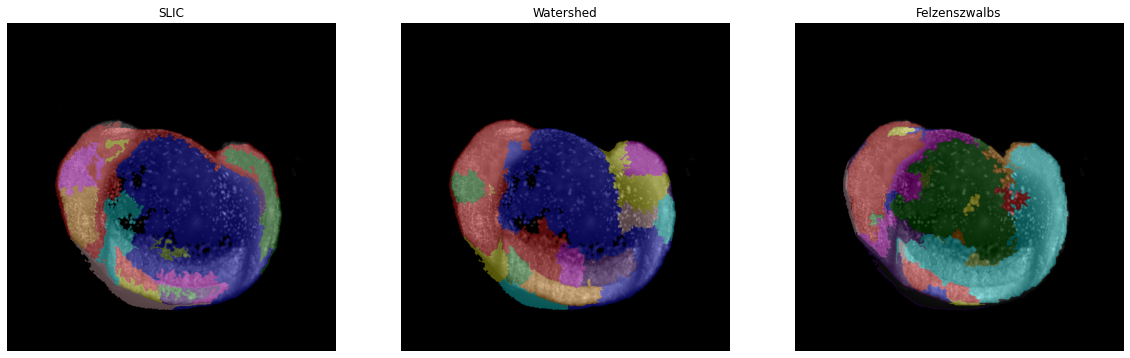

In [138]:
# Adopted from: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_mean_color.html#sphx-glr-auto-examples-segmentation-plot-rag-mean-color-py

### threshod cut
def t_cut(img, segments):
    g = graph.rag_mean_color(img, segments, mode='distance')
    segments_cut = graph.cut_threshold(segments, g, thresh=0.08)
    out_cut = color.label2rgb(segments_cut, img, bg_label=0)
    return out_cut

slic_cut = t_cut(slice_t, segments_slic)
watershed_cut = t_cut(slice_t, segments_watershed)
fz_cut = t_cut(slice_t, segments_fz)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(slic_cut)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(watershed_cut)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(fz_cut)
ax[2].axis('off')

(-0.5, 511.5, 511.5, -0.5)

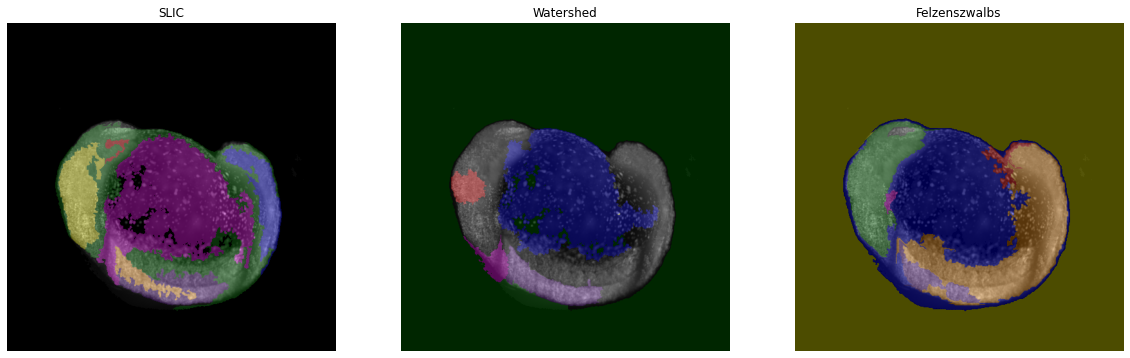

In [149]:
# Adopted from: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_merge.html#sphx-glr-auto-examples-segmentation-plot-rag-merge-py

### RAG merging
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])

def m_h(img, segments):
    g = graph.rag_mean_color(img, segments, mode='distance')
    segments_mh = graph.merge_hierarchical(segments, g, thresh=0.2, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
    out_mh = color.label2rgb(segments_mh, img, bg_label=0)
    return out_mh

slic_cut = m_h(slice_t, segments_slic)
watershed_cut = m_h(slice_t, segments_watershed)
fz_cut = m_h(slice_t, segments_fz)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(slic_cut)
ax[0].set_title('SLIC')
ax[0].axis('off')
ax[1].set_title('Watershed')
ax[1].imshow(watershed_cut)
ax[1].axis('off')
ax[2].set_title('Felzenszwalbs')
ax[2].imshow(fz_cut)
ax[2].axis('off')